# 작업환경 구성하기

In [1]:
import os
import glob
import time
import PIL

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import imageio

print(tf.__version__)
print(imageio.__version__)

2.6.0
2.9.0


# 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (text_x, _) = cifar10.load_data() 
#분류문제가 아니기 때문에 y는 언더스코어로 해당 데이터 무시 

train_x.shape

(50000, 32, 32, 3)

In [3]:
print('max pixel', train_x.max())
print('min pixel', train_x.min())

max pixel 255
min pixel 0


In [4]:
# -1 ~ 1로 정규화하기
train_x = (train_x - 127.5) / 127.5

print('max pixel', train_x.max())
print('min pixel', train_x.min())

max pixel 1.0
min pixel -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

In [6]:
#컬러 이미지이므로 채널수는 3이 된다.
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

print(train_x[0].shape)

(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


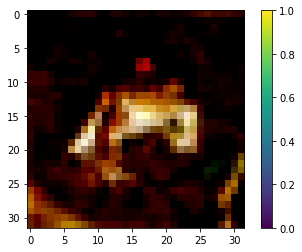

In [7]:
plt.imshow(train_x[0].reshape(32 ,32, 3))
plt.colorbar()
plt.show()

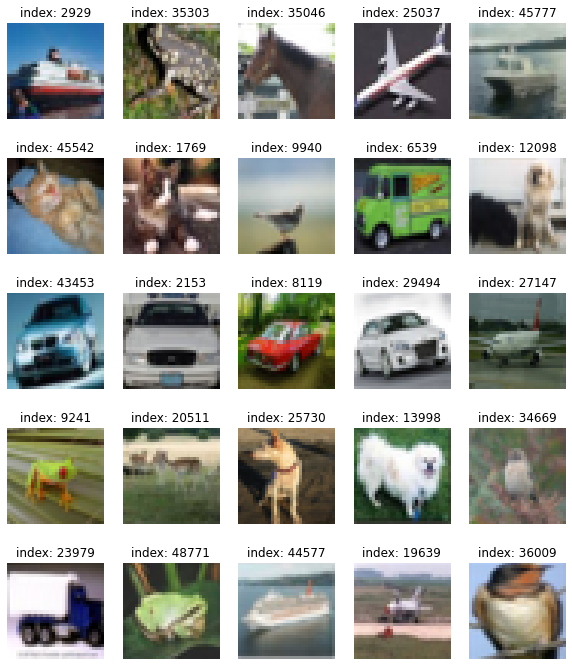

In [8]:
plt.figure(figsize=(10, 12))

#랜덤하게 25개의 인덱스 추출
random_indices = np.random.choice(len(train_x), 25, replace=False)

for i in range(25):
    plt.subplot(5 ,5, i+1)
    plt.imshow((train_x[random_indices[i]] + 1) / 2)
    plt.title(f'index: {random_indices[i]}')
    plt.axis('off')
plt.show()

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자 모델 구현하기

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))

    return model


In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

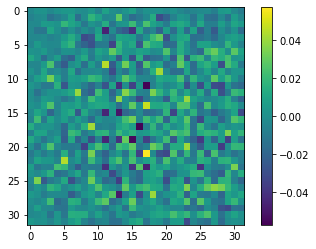

In [15]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# 판별자 모델 구하기

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    #첫번째 conv2d층
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #두번째 conv2d층
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #세번째 플래튼 층
    model.add(layers.Flatten())
    
    #네번째 dense층
    model.add(layers.Dense(1)) #맞는지 아닌지를 가리는거라 1
    
    return model
    

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
#가짜이미지를 판별자에 넣어보기
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00082153]], dtype=float32)>

# 손실함수와 최적화 함수 구현하기

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [23]:
#생성자와 판별자의 옵티마이저는 각각 설정해주어야 한다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 상세 기능 구현

In [25]:
# 1개의 미니배치 훈련과정을 처리하는 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [26]:
# 훈련과정 동안 생성한 이미지를 시각화하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)  # [0, 1] 범위로 조정
        plt.axis('off')
   
    plt.savefig(os.path.join(os.getenv('HOME'), f'aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{epoch:04d}_iter_{it:03d}.png'))

    plt.show()

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [28]:
#몇 에폭마다 모델을 저장하는 체크포인트 모듈

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 학습진행하기

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

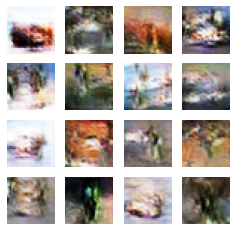

Time for training : 4822 sec


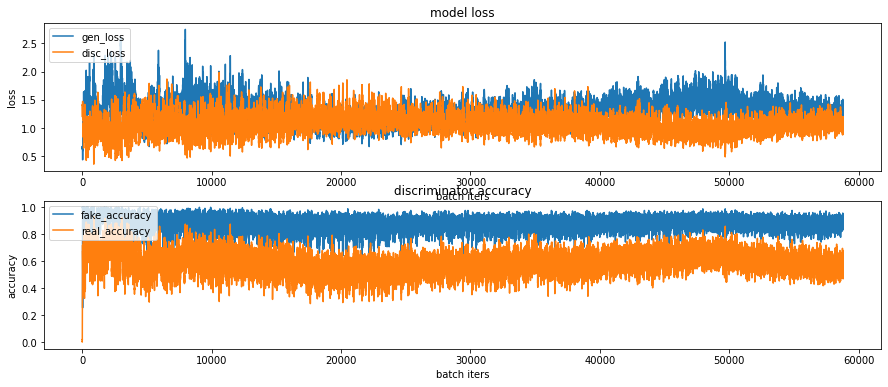

CPU times: user 1h 22min 40s, sys: 6min 29s, total: 1h 29min 10s
Wall time: 1h 20min 26s


In [133]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정 시각화하기

In [134]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 2523718 Sep 20 17:34 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![](https://github.com/ImHyunSeok/lim/blob/master/fashion_mnist_dcgan.gif?raw=true)

![](https://github.com/ImHyunSeok/lim/blob/master/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C.png?raw=true)

![](https://github.com/ImHyunSeok/lim/blob/master/train_history_0299.png?raw=true)


# 모델을 개선해보자


In [31]:

def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Seventh: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Eighth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', activation='tanh'))

    return model

In [32]:
generator_two = make_generator_model()

generator_two.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [33]:
#노이즈생성
noise = tf.random.normal([1,100])
generated_image = generator_two(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [34]:
# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    #첫번째 conv2d층
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', input_shape=[32,32,3]))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    #플래튼 층
    model.add(layers.Flatten())
    
    #dense층
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) #맞는지 아닌지를 가리는거라 1
    
    return model
    


In [35]:
discriminator_two = make_discriminator_model()

discriminator_two.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)      

In [36]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

In [37]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

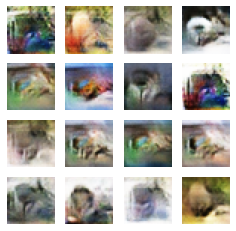

Time for training : 3208 sec


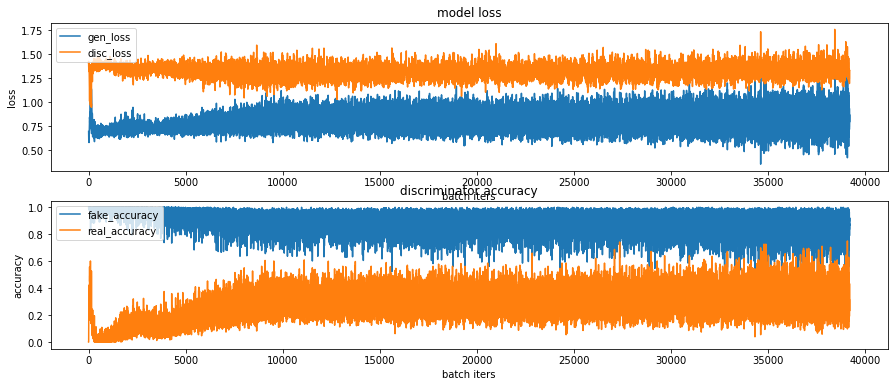

CPU times: user 54min 55s, sys: 4min 11s, total: 59min 7s
Wall time: 53min 32s


In [38]:
%%time
train(train_dataset, EPOCHS, save_every)

![](https://github.com/ImHyunSeok/lim/blob/master/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C%20(1).png?raw=true)

![](https://github.com/ImHyunSeok/lim/blob/master/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C%20(2).png?raw=true)

# 3번째 실험

In [37]:

def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Seventh: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Eighth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', activation='tanh'))

    return model

In [38]:
generator_two = make_generator_model()

generator_two.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 128)        

In [39]:
#노이즈생성
noise = tf.random.normal([1,100])
generated_image = generator_two(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [40]:
# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    #첫번째 conv2d층
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', input_shape=[32,32,3]))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    #플래튼 층
    model.add(layers.Flatten())
    
    #dense층
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) #맞는지 아닌지를 가리는거라 1
    
    return model
    


In [41]:
discriminator_two = make_discriminator_model()

discriminator_two.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 128)      

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [43]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

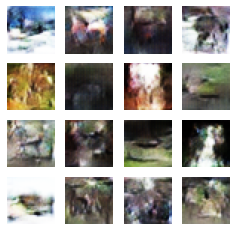

Time for training : 8510 sec


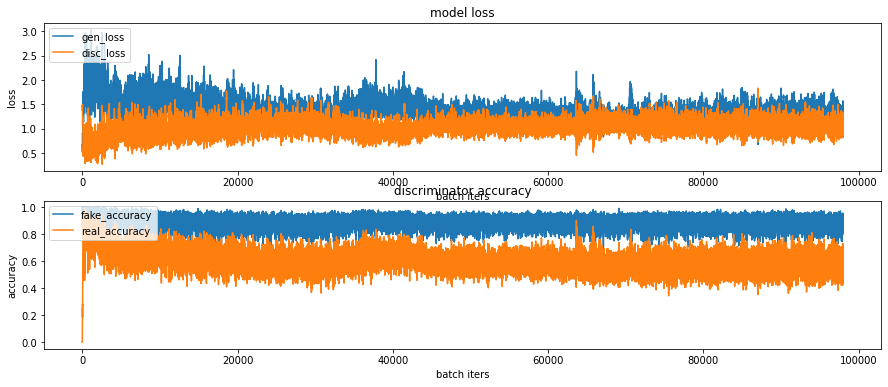

CPU times: user 2h 26min 4s, sys: 10min 55s, total: 2h 37min
Wall time: 2h 21min 56s


In [44]:
%%time
train(train_dataset, EPOCHS, save_every)

In [45]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 3186968 Sep 21 01:03 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


# 결론

## 첫번째 시도

- 노드의 모델을 따라 학습하였음. 에폭300

- 300번을 다 돌린 후의 이미지는 알아볼 수 없음 (실패)


![](https://github.com/ImHyunSeok/lim/blob/master/fashion_mnist_dcgan.gif?raw=true)

![](https://github.com/ImHyunSeok/lim/blob/master/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C.png?raw=true)

![](https://github.com/ImHyunSeok/lim/blob/master/train_history_0299.png?raw=true)

    

## 두번째 시도

- 모델의 깊이를 더 깊게 하고, 옵티마이저를 RMSprop으로 변경 , 에폭 200

- 첫번째 모델보다는 조금 더 사물의 윤곽이 보이는 듯한 이미지

- fake accuracy는 학습이 진행될수록 점점 내려감

![](https://github.com/ImHyunSeok/lim/blob/master/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C%20(1).png?raw=true)

![](https://github.com/ImHyunSeok/lim/blob/master/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C%20(2).png?raw=true)

## 세번째 시도

- 두번째 모델에서 옵티마이저를 Adam으로 변경, 에폭 500

- 에폭을 충분히 주었음에도 예상과는 다르게 육안으로 확인가능한 이미지가 생성되지않음

![](https://github.com/ImHyunSeok/lim/blob/master/fashion_mnist_dcgan%20(1).gif?raw=true)

![](https://github.com/ImHyunSeok/lim/blob/master/train_history_0499.png?raw=true)
